# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

**О датасете:** Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Задача:** Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Загрузка и подготовка данных

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

### Исследование данных 1 региона (geo_0)

In [3]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


#### распределение независимых переменных

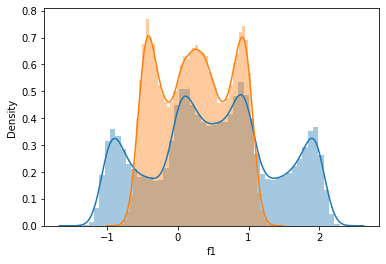

In [5]:
sns.distplot(df1['f0']);
sns.distplot(df1['f1']);

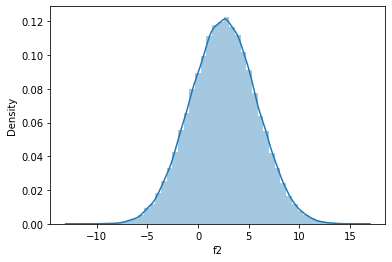

In [6]:
sns.distplot(df1['f2']);

#### распределение зависимой переменной

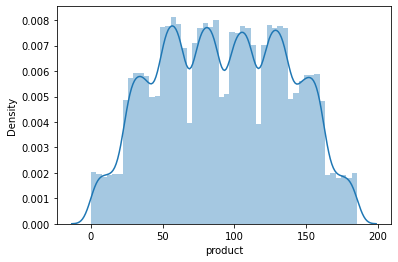

In [7]:
sns.distplot(df1['product']);

In [8]:
df1.shape

(100000, 5)

In [9]:
df1['id'].value_counts().head()

fiKDv    2
74z30    2
TtcGQ    2
A5aEY    2
bxg6G    2
Name: id, dtype: int64

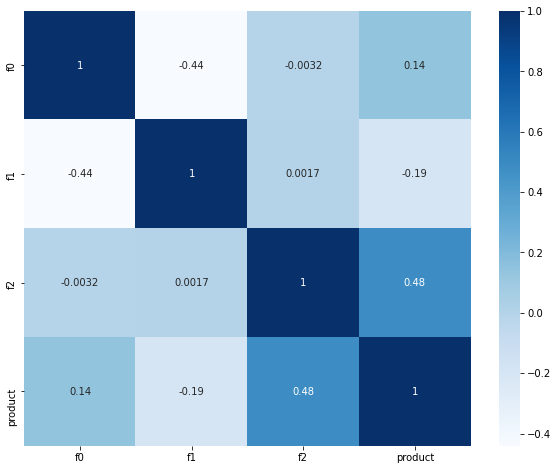

In [10]:
#посмотрим на связь целевой переменной и признаков
plt.figure(figsize=(10,8))
sns.heatmap(df1.corr(),
            cmap='Blues', #палитра
            annot=True);

#### Проверка на наличие дубликатов

In [11]:
df1.duplicated().sum()

0

Вывод по региону 1:
- пропусков и явных дубликатов в данных не обнаружено
- распеределения f0, f1 и product в первом регионе явно отклоняются от норммального
- между независимыми переменными f0 и f1 есть не сильная отрицательная линейная свяязь (R-Пирсона = 0.44), что может стать причиной мультиколлинеарности
- наибольшую связь с зависимой переменной имеет f2: не сильная положительная линейная связь (R-Пирсона = 0.48)

### Исследование данных 2 региона (geo_1)

In [12]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


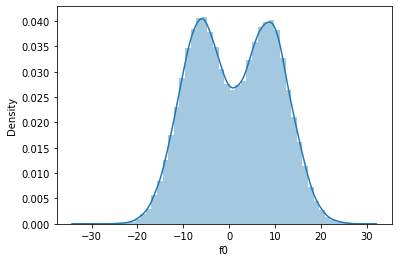

In [14]:
sns.distplot(df2['f0']);

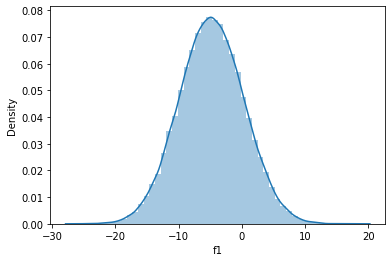

In [15]:
sns.distplot(df2['f1']);

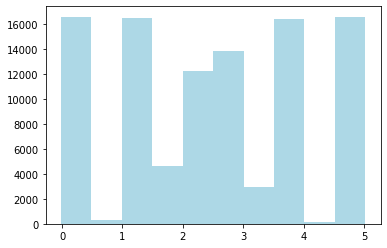

In [16]:
plt.hist(df2['f2'], color = 'lightblue');

#### Распределение зависимой переменной

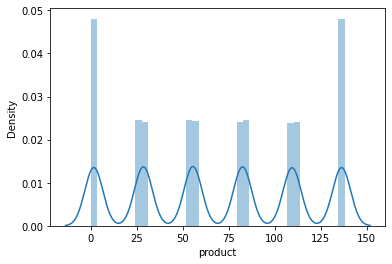

In [17]:
sns.distplot(df2['product']);

In [18]:
df2['id'].value_counts().head()

LHZR0    2
5ltQ6    2
bfPNe    2
wt4Uk    2
eWXVZ    1
Name: id, dtype: int64

In [19]:
df2.shape

(100000, 5)

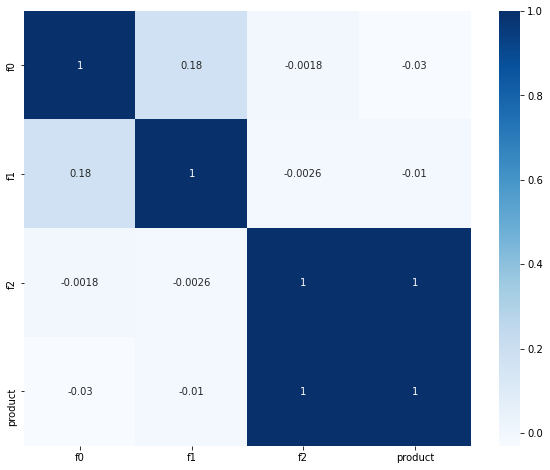

In [20]:
#посмотрим на связь целевой переменной и признаков
plt.figure(figsize=(10,8))
sns.heatmap(df2.corr(),
            cmap='Blues', #палитра
            annot=True);

#### Проверка на наличие дубликатов

In [21]:
df2.duplicated().sum()

0

Вывод по региону 2:
- пропусков и явных дубликатов в данных не обнаружено
- распеределения f0, f2 и product в явно отклоняются от норммального
- между независимыми переменными f0 и f1 есть не сильная положительная линейная свяязь (R-Пирсона = 0.18), что может стать причиной мультиколлинеарности
- наибольшую связь с зависимой переменной имеет f2: есть сильная положительная линейная связь (R-Пирсона = 1), две другие независимые переменные практически не связаны с зависимой (связь около 0)

### Исследование данных 3 региона (geo_2)

In [22]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [23]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [24]:
df3.shape

(100000, 5)

#### Распределение независимых переменных

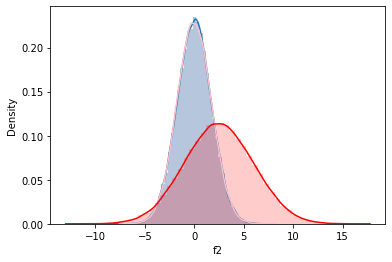

In [25]:
sns.distplot(df3['f0']);
sns.distplot(df3['f1'], hist_kws=dict(alpha=0.2), color = 'pink');
sns.distplot(df3['f2'], hist_kws=dict(alpha=0.2), color = 'red');

#### Распрпеделение зависимой переменной

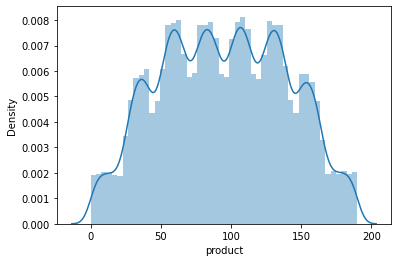

In [26]:
sns.distplot(df3['product']);

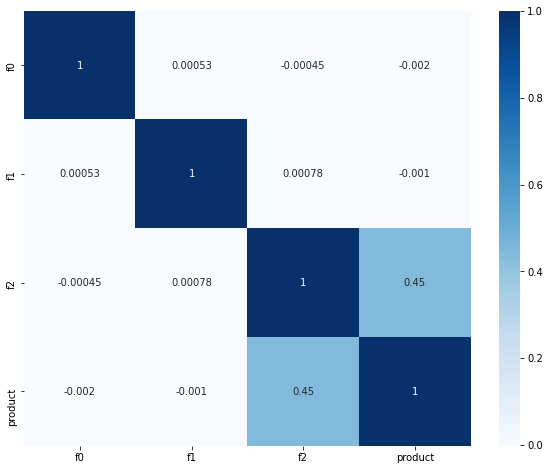

In [27]:
#посмотрим на связь целевой переменной и признаков
plt.figure(figsize=(10,8))
sns.heatmap(df3.corr(),
            cmap='Blues', #палитра
            annot=True);

#### Проверка на наличие дубликатов

In [28]:
df3.duplicated().sum()

0

In [29]:
df3['id'].value_counts().head()

xCHr8    2
Vcm5J    2
KUPhW    2
VF7Jo    2
5UzYu    1
Name: id, dtype: int64

In [30]:
df3[df3['id']=='KUPhW']

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


Видим, что если ID скважины повторяется, то это не дубликаты. Одна скаважина может иметь две точки.

Вывод по региону 3:
- пропусков и явных дубликатов в данных не обнаружено
- наибольшую связь с зависимой переменной имеет f2: есть слабая положительная линейная связь (R-Пирсона = 0.45), две другие независимые переменные практически не связаны с зависимой (связь около 0)

## Обучение и проверка модели

### Подготовка признаков

ID - переменная, которая не понадобится нам в дальнейшем моделировании, можем исключить ее из датасета

In [31]:
df3 = df3.drop('id', axis = 1)

In [32]:
df2 = df2.drop('id', axis = 1)

In [33]:
df1 = df1.drop('id', axis = 1)

In [34]:
features_1 = df1.drop('product', axis = 1)
target_1 = df1['product']

features_2 = df2.drop('product', axis = 1)
target_2 = df2['product']

features_3 = df3.drop('product', axis = 1)
target_3 = df3['product']

### Разбиение на обучающую и тестовую выборки

In [35]:
features1_train, features1_test, target1_train, target1_test = train_test_split(features_1, 
                                                                                target_1, 
                                                                                test_size=0.25, 
                                                                                random_state=12345)
print(features1_train.shape)
features1_test.shape

(75000, 3)


(25000, 3)

In [36]:
features2_train, features2_test, target2_train, target2_test = train_test_split(features_2, 
                                                                                target_2, 
                                                                                test_size=0.25, 
                                                                                random_state=12345)
print(features2_train.shape)
features2_test.shape

(75000, 3)


(25000, 3)

In [37]:
features3_train, features3_test, target3_train, target3_test = train_test_split(features_3, 
                                                                                target_3, 
                                                                                test_size=0.25, 
                                                                                random_state=12345)
print(features3_train.shape)
features3_test.shape

(75000, 3)


(25000, 3)

### Подготовка независимых переменных к моделированию (масштабирование)

In [38]:
#масштабриуем Х для 1 региона
scaler = StandardScaler() #импортируем scaler для стандартизации данных
scaler.fit(features1_train)
features1_train = scaler.transform(features1_train) 
features1_test = scaler.transform(features1_test)

In [39]:
#масштабриуем Х для 2 региона
scaler = StandardScaler() #импортируем scaler для стандартизации данных
scaler.fit(features2_train)
features2_train = scaler.transform(features2_train) 
features2_test = scaler.transform(features2_test)

In [40]:
#масштабриуем Х для 3 региона
scaler = StandardScaler() #импортируем scaler для стандартизации данных
scaler.fit(features3_train)
features3_train = scaler.transform(features3_train) 
features3_test = scaler.transform(features3_test)

### Построение моделей

In [41]:
#прогноз для региона 1
model_1 = LinearRegression()
model_1.fit(features1_train, target1_train)
pred_1 = model_1.predict(features1_test)
mse_1 = mean_squared_error(target1_test, pred_1)
rmse_1 = mse_1 ** 0.5 #более чувствительно к большим ошибкам
print('RMSE:', rmse_1)
print('R2: ', r2_score(target1_test, pred_1))
print('MAE: ', mean_absolute_error(target1_test, pred_1))
print('Реальный средний объем запасов в скважине:', target1_test.mean())
print('Предсказанный средний объем запасов в скважине:', pred_1.mean())

RMSE: 37.5794217150813
R2:  0.27994321524487786
MAE:  30.919600777151313
Реальный средний объем запасов в скважине: 92.07859674082927
Предсказанный средний объем запасов в скважине: 92.59256778438035


In [42]:
#прогноз для региона 2
model_2 = LinearRegression()
model_2.fit(features2_train, target2_train)
pred_2 = model_2.predict(features2_test)
mse_2 = mean_squared_error(target2_test, pred_2)
rmse_2 = mse_2 ** 0.5 #более чувствительно к большим ошибкам
print('RMSE:', rmse_2)
print('R2: ', r2_score(target2_test, pred_2))
print('MAE: ', mean_absolute_error(target2_test, pred_2))
print('Реальный средний объем запасов в скважине:', target2_test.mean())
print('Предсказанный средний объем запасов в скважине:', pred_2.mean())

RMSE: 0.893099286775617
R2:  0.9996233978805127
MAE:  0.7187662442124758
Реальный средний объем запасов в скважине: 68.72313602435997
Предсказанный средний объем запасов в скважине: 68.728546895446


In [43]:
#прогноз для региона 3
model_3 = LinearRegression()
model_3.fit(features3_train, target3_train)
pred_3 = model_3.predict(features3_test)
mse_3 = mean_squared_error(target3_test, pred_3)
rmse_3 = mse_3 ** 0.5 #более чувствительно к большим ошибкам
print('RMSE:', rmse_3)
print('R2: ', r2_score(target3_test, pred_3))
print('MAE: ', mean_absolute_error(target3_test, pred_3))
print('Реальный средний объем запасов в скважине:', target3_test.mean())
print('Предсказанный средний объем запасов в скважине:', pred_3.mean())

RMSE: 40.02970873393434
R2:  0.20524758386040443
MAE:  32.792652105481814
Реальный средний объем запасов в скважине: 94.88423280885438
Предсказанный средний объем запасов в скважине: 94.96504596800489


Я предположила, что можно повысить R2, убрав плохо коррелирующие с зависимой переменной независимые переменнные. Я отобрала переменную f2, у которой с production r-Пиросона = 0.45. 

In [44]:
features_add_train= features3_train[:,2]
features_add_test = features3_test[:,2]
features_add_train= features_add_train.reshape(-1, 1)
features_add_test = features_add_test.reshape(-1, 1)

In [45]:
model_add = LinearRegression()
model_add.fit(features_add_train, target3_train)
pred_add = model_add.predict(features_add_test)
mse_add = mean_squared_error(target3_test, pred_add)
rmse_add = mse_add ** 0.5 #более чувствительно к большим ошибкам
print('RMSE:', rmse_3)
print('R2: ', r2_score(target3_test, pred_add))
print('MAE: ', mean_absolute_error(target3_test, pred_add))
print('Реальный средний объем запасов в скважине:', target3_test.mean())
print('Предсказанный средний объем запасов в скважине:', pred_add.mean())

RMSE: 40.02970873393434
R2:  0.2052753633827945
MAE:  32.7922421367123
Реальный средний объем запасов в скважине: 94.88423280885438
Предсказанный средний объем запасов в скважине: 94.96585247522388


Оставив одну переменную Х (f2) качество модели улучшилось на 0,00003. Мы видим, что при имеющихся данных значительно увеличить R2 не получится, к тому же, мы не знаем, что значат f0, f1, f2. 

Лучшая модель - модель, построенная для региона geo1 (model_2). R2 = 0.99. Он достигается за счет практически 100% корреляции между f2 и зависимой переменной. RMSE и MAE модели также наименьшие из всех трех моделей. 

## Подготовка к расчёту прибыли

### Все ключевые значения для расчётов сохраните в отдельных переменных.

Предсказанные объемы добычи сохранены в переменных pred_1 (для geo_0), pred_2 (для geo_1) и pred_3 (для geo_2)

In [46]:
pred_1 = pd.Series(pred_1)
pred_2 = pd.Series(pred_2)
pred_3 = pd.Series(pred_3)

### Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 


In [47]:
BUDGET = 10000000000
ONE_BAR_PROFIT = 450000 #Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
NUM_ITEMS = 200

In [48]:
min_prod_200 = BUDGET/ONE_BAR_PROFIT
min_prod_200

22222.222222222223

Получается, что нам необходимо отобрать регионы, где 200 наиболее продуктивных скважин производят не менее min_prod (22222.222222222223 объема)

In [49]:
one_item_prod_mean = BUDGET/NUM_ITEMS/ONE_BAR_PROFIT
one_item_prod_mean

111.11111111111111

Средний же объем производства одной скважины в регионе должен быть более 111.11111111111111

In [50]:
print('Средний объём запасов в скважине в первом регионе:', df1['product'].mean())
print('Средний объём запасов в скважине во втором регионе:', df2['product'].mean())
print('Средний объём запасов в скважине в третьем регионе:', df3['product'].mean())

Средний объём запасов в скважине в первом регионе: 92.50000000000001
Средний объём запасов в скважине во втором регионе: 68.82500000000002
Средний объём запасов в скважине в третьем регионе: 95.00000000000004


**Вывод:** Ни в одном из регионов средний объем запасов в скважине не достигает минимального порога в 111 тыс.баррелей. Наиболее же близкие к этому порогу значения наблюдаются в первом и третьем регионах - в регионах, в которых наша модель имеет наиболее низкую предсказательную силу (R2 = 0.27 и 0.20 соответственно) 

## Расчёт прибыли и рисков 

In [51]:
#Функция для подсчета прибыли
def revenue(predicted_target, real_target, num_of_items_to_select):#на вход поступают предсказанные значения объема сырья для всех скважин региона
    probs_sorted = predicted_target.sort_values(ascending = False)
    selected_items = real_target[probs_sorted.index][:num_of_items_to_select]
    volume = selected_items.sum()
    profit = volume*ONE_BAR_PROFIT - BUDGET     
    return profit

In [52]:
#меняем индексы в целевой переменной, чтобы посчитать прибыль 
target1_test = target1_test.reset_index(drop=True)
target2_test = target2_test.reset_index(drop=True)
target3_test = target3_test.reset_index(drop=True)
target1_test

0         10.038645
1        114.551489
2        132.603635
3        169.072125
4        122.325180
            ...    
24995    170.116726
24996     93.632175
24997    127.352259
24998     99.782700
24999    177.821022
Name: product, Length: 25000, dtype: float64

### Прибыль и риски разработки модели в первом регионе (geo_0)

In [53]:
state = np.random.RandomState(12345)

Средняя выручка: 425938526.91059244
Риск убытков: 6.0 %
В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале: [ -102090094.83793654 , 947976353.3583689 ]


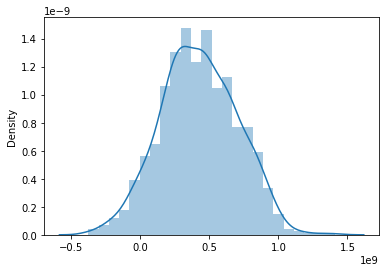

In [54]:
values = []
losses = 0
for i in range(1000):
    target_subsample = target1_test.sample(n = 500, replace = True, random_state = state)
    pred_subsample = pred_1[target_subsample.index]
    profit_per_sample = revenue(pred_subsample, target_subsample, 200)
    values.append(profit_per_sample)
    if profit_per_sample<0: #расчет рисков
        losses+=1
        
values = pd.Series(values)
geo_0_mean = values.mean()
geo_0_losses_share = (losses/1000)*100

sns.distplot(values)

lower_1 = values.quantile(0.025)
upper_1 = values.quantile(0.975)
print("Средняя выручка:", geo_0_mean)
print('Риск убытков:',geo_0_losses_share, '%' )
print('В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале:', '[',lower_1, ',', upper_1, ']')

### Прибыль и риски разработки модели во втором регионе (geo_1)

Средняя выручка: 518259493.6973249
Риск убытков: 0.3 %
В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале: [ 128123231.43308444 , 953612982.0669085 ]


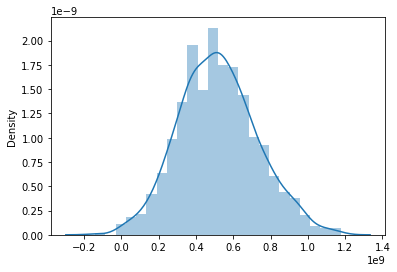

In [55]:
values = []
losses = 0
for i in range(1000):
    target_subsample = target2_test.sample(n = 500, replace = True, random_state = state)
    pred_subsample = pred_2[target_subsample.index]
    profit_per_sample = revenue(pred_subsample, target_subsample, 200)
    values.append(profit_per_sample)
    if profit_per_sample<0:
        losses+=1
        
values = pd.Series(values)
geo_1_mean = values.mean()
geo_1_losses_share = (losses/1000)*100

sns.distplot(values)

lower_2 = values.quantile(0.025)
upper_2 = values.quantile(0.975)
print("Средняя выручка:", geo_1_mean)
print('Риск убытков:',geo_1_losses_share, '%' )
print('В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале:', '[',lower_2, ',', upper_2, ']')

### Прибыль и риски разработки модели в третьем регионе (geo_2)

Средняя выручка: 420194005.3440501
Риск убытков: 6.2 %
В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале: [ -115852609.16001143 , 989629939.8445739 ]


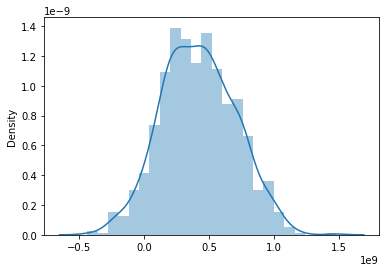

In [56]:
values = []
losses = 0
for i in range(1000):
    target_subsample = target3_test.sample(n = 500, replace = True, random_state = state)
    pred_subsample = pred_3[target_subsample.index]
    profit_per_sample = revenue(pred_subsample, target_subsample, 200)
    values.append(profit_per_sample)
    if profit_per_sample<0:
        losses+=1
        
values = pd.Series(values)
geo_2_mean = values.mean()
geo_2_losses_share = (losses/1000)*100

sns.distplot(values)

lower_3 = values.quantile(0.025)
upper_3 = values.quantile(0.975)
print("Средняя выручка:", geo_2_mean)
print('Риск убытков:',geo_2_losses_share, '%' )
print('В генеральной совокупности с вероятностью 95% истинное среднее лежит в интервале:', '[',lower_3, ',', upper_3, ']')

In [57]:
#соберем все характеристики регионов в одну таблицу
index = ['geo_0', 'geo_1', 'geo_2']
columns = ['mean', 'losses_risk, %', 'conf_int_left', 'conf_int_right']
data = [[geo_0_mean, geo_0_losses_share,lower_1, upper_1],
       [geo_1_mean, geo_1_losses_share,lower_2, upper_2],
       [geo_2_mean, geo_2_losses_share,lower_3, upper_3]]
df = pd.DataFrame(data = data,
                 index = index,
                 columns = columns)
df

,mean,"losses_risk, %",conf_int_left,conf_int_right
geo_0,4.259385e+08,6.0,-1.020901e+08,9.479764e+08
geo_1,5.182595e+08,0.3,1.281232e+08,9.536130e+08
geo_2,4.201940e+08,6.2,-1.158526e+08,9.896299e+08


Выводы: 
- Исходя из подсчитанной средней прибыли по трем регионам, наиболее высокая средняя прибыль прогнозируется во втором регионе (geo_1), также для этого региона прогнозируются наиболее низкие риски убытков. Таким образом, для для разработки скважин рекомендуется именно этот регион. 
- В генеральной совокупности с вероятностью 95% средняя прибыль от разработки скважин в регионе 2 (geo_1) лежит в интервале: 128 123 231.4 - 953 612 982.1 руб и стремится к 518 259 493.7 руб. При этом, риск убытков в этом регионе составляет 0.3%
- О модели линейной регресси, при помощи которой были получены предсказания: это лучшая модель по показателям ошибок ( RMSE и MAE модели наименьшие из всех трех моделей) и R2 (R2 = 0.99).Стоит учитывать, что такие характеристики модели достигаются за счет 100% корреляции между f2 и зависимой переменной.